# LDA Model

In this document, I apply an LDA model to the pre-processed plot summaries and use coherence scores to optimise the hyperparameters. 


### Setup

In [1]:
import gensim
import pandas as pd
from nltk.tokenize import word_tokenize
import string
import nltk
import numpy as np
import re
import tqdm
from pprint import pprint# Gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel# spaCy for preprocessing
#import spacy# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel

### Importing the pre-processed plot summaries

In [4]:
stringed_data = pd.read_csv('./Data/stringed_plots.csv')
stringed_data[:5]

,Unnamed: 0,0
0,0,"['kaisa', 'scot', 'successful', 'london', 'law..."
1,1,"['plague', 'endless', 'jenny', 'suspect', 'chi..."
2,2,"['novel', 'young', 'nicotine', 'addict', 'trav..."
3,3,"['bronx', 'joe', 'sir', 'irish', 'good', 'guy'..."
4,4,"['woman', 'promise', 'make', 'suppose', 'marry..."


The below code converts the above from a pandas dataframe to a list of lists.

In [5]:
plots=[]
for i in range(0,len(stringed_data)):
    data=np.array(stringed_data.iloc[i])
    text=data[1]
    text=text.replace(',','')
    text=text.replace('[','')
    text=text.replace(']','')
    text=text.replace("'",'')
    tokens=word_tokenize(text)
    plots.append(tokens)
    
plots[:5]

[['kaisa',
  'scot',
  'successful',
  'london',
  'lawyer',
  'coke',
  'night',
  'stand',
  'aberdeen',
  'story',
  'begging',
  'fly',
  'collect',
  'alcoholic',
  'dad',
  'hasnt',
  'see',
  'impatient',
  'agree',
  'ruse',
  'mom',
  'dying',
  'want',
  'daughter',
  'trip',
  'get',
  'complicate',
  'drunk',
  'hot',
  'temper',
  'ban',
  'airline',
  'go',
  'ferry',
  'car',
  'need',
  'great',
  'deal',
  'help',
  'along',
  'way',
  'sweet',
  'lorry',
  'driver',
  'name',
  'clive',
  'reach',
  'death',
  'find',
  'stability'],
 ['plague',
  'endless',
  'jenny',
  'suspect',
  'child',
  'responsible',
  'brutal',
  'murder',
  'mother'],
 ['novel',
  'young',
  'nicotine',
  'addict',
  'traveler',
  'name',
  'richard',
  'avid',
  'pop',
  'culture',
  'buff',
  'particular',
  'love',
  'video',
  'vietnam',
  'war',
  'hotel',
  'bangkok',
  'map',
  'left',
  'strange',
  'whack',
  'commit',
  'suicide',
  'lead',
  'legendary',
  'island',
  'paradise',

### Building the LDA model

First we create the dictionary.

In [6]:
dictionary = gensim.corpora.Dictionary(plots)

count = 0
for k,v  in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break
        
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
# gets rid of too common or uncommon words

0 aberdeen
1 agree
2 airline
3 alcoholic
4 along
5 ban
6 begging
7 car
8 clive
9 coke
10 collect


Next we make the corpus.

In [7]:
# Term Document Frequency 
corpus = [dictionary.doc2bow(text) for text in plots ]  
# View 
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1)]]


Now we are ready to fit the model. At first I will just choose to try 10 topics.

In [8]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

The next code prints the top words in each topic. From this we can see some clear links between words in a topic, which sometimes appear to reflect a genre. For example, words like 'murder', 'killer', 'body' and 'survive' indicate that topic 5 may correspond to horror films. There are also many words in topic 6 (for example 'high', 'school', 'group') which indicate that this topic may be formed of words from plots of films aimed at teenagers, so the topics may help provide information on the target audience. 

In [9]:
pprint(lda_model.print_topics())

[(0,
  '0.042*"confront" + 0.033*"friendship" + 0.032*"form" + 0.025*"pay" + '
  '0.023*"king" + 0.023*"reality" + 0.021*"train" + 0.019*"artist" + '
  '0.019*"say" + 0.018*"magic"'),
 (1,
  '0.064*"world" + 0.030*"force" + 0.023*"war" + 0.023*"face" + '
  '0.018*"mission" + 0.017*"dangerous" + 0.016*"future" + 0.016*"college" + '
  '0.015*"power" + 0.015*"black"'),
 (2,
  '0.026*"life" + 0.018*"new" + 0.018*"family" + 0.017*"young" + 0.016*"find" '
  '+ 0.016*"take" + 0.012*"get" + 0.012*"become" + 0.011*"old" + 0.011*"time"'),
 (3,
  '0.053*"story" + 0.034*"follow" + 0.025*"journey" + 0.024*"film" + '
  '0.023*"set" + 0.022*"love" + 0.020*"base" + 0.019*"adventure" + '
  '0.019*"first" + 0.017*"couple"'),
 (4,
  '0.076*"mysterious" + 0.036*"girlfriend" + 0.025*"crew" + 0.025*"strange" + '
  '0.024*"island" + 0.021*"hollywood" + 0.017*"appear" + 0.017*"neighbor" + '
  '0.016*"cast" + 0.016*"mean"'),
 (5,
  '0.038*"murder" + 0.025*"survive" + 0.025*"truth" + 0.020*"history" + '
  '0.01

We can make the topics easier to investigate using a visualisation.

In [10]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis

C:\Users\user\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.282811  0.053768       1        1  41.480106
6     -0.164234  0.297933       2        1  10.501584
3     -0.218744 -0.267801       3        1   8.921842
8      0.059141 -0.036598       4        1   8.815485
1      0.150869  0.109443       5        1   8.689225
9      0.153938  0.063334       6        1   7.309804
5      0.084758 -0.207615       7        1   5.459290
4      0.082366 -0.005869       8        1   3.152133
7      0.072068 -0.004874       9        1   3.002773
0      0.062650 -0.001720      10        1   2.667757, topic_info=            Term         Freq        Total Category  logprob  loglift
155        world  1067.000000  1067.000000  Default  30.0000  30.0000
30         story   902.000000   902.000000  Default  29.0000  29.0000
984   mysterious   458.000000   458.000000  Default  28.0000  28.0000
106        woman   619.000000   619.000000  Default  27.0000  27.0000
627       follow   583.000000   583.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
1936     distant    45.017006    46.143191  Topic10  -4.7271   3.5992
2217      inside    45.005910    46.132580  Topic10  -4.7273   3.5992
2126         lay    44.568547    45.695261  Topic10  -4.7371   3.5990
1486      thrill    44.157976    45.284138  Topic10  -4.7464   3.5987
2531       oscar    42.629818    43.755979  Topic10  -4.7816   3.5979

[361 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
157       4  0.991242       able
994       5  0.994734     action
68        3  0.997124  adventure
1897     10  0.983729    african
595       3  0.993985        age
...     ...       ...        ...
155       5  0.994324      world
617       3  0.990958      write
156       1  0.999101       year
1887      1  0.998056       york
67        1  0.998805      young

[365 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 4, 9, 2, 10, 6, 5, 8, 1])

We can see that many of the topics are overlapping, and topics 8,9 and 10 appear to be very similar, which indicates that it might be better to use fewer topis in the model.

### Hyperparameter optimisation

The LDA model has 3 hyperparameters that we can vary:
1. Number of Topics 
2. Dirichlet hyperparameter alpha: Document-Topic Density
3. Dirichlet hyperparameter beta: Word-Topic Density.

We will optimise these for our data by performing a series of sensitivity tests in sequence, one parameter at a time by keeping others constant. We will run these tests over the two different validation corpus sets for cross validation purposes.

We will use the coherence as a performance metric, which measures hoq often pairs of words appear together. In particular, we will use extrinsic coherence, c_v, which compares to standard reference documents.

First I compute a baseline coherence score using the model we already fitted.

In [9]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=plots, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.35614253804641927


The higher the coherence the better, so we will attempt to improve on this by tuning the hyperparameters.

In [10]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=plots, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

Since the visualisation shows that we should expect fewer topics to better represent the data, I chose to vary the number of topics between 3 and 10.

In [11]:
grid = {}
grid['Validation_Set'] = {}

# Topics values
min_topics = 3
max_topics = 10
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha values
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta values
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Cross validation 
num_of_docs = len(corpus)
corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]

corpus_title = ['75% Corpus', '100% Corpus']

model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a while to run so I've saved the results for convenience
if 1 == 1:
    pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=dictionary, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('./lda_tuning_results2.csv', index=False)
    pbar.close()

100%|██████████| 420/420 [10:36:58<00:00, 91.00s/it]     


In [11]:
optim_data = pd.read_csv('./Data/lda_tuning_results2.csv')
optim_data[:5]

,Validation_Set,Topics,Alpha,Beta,Coherence
0,75% Corpus,3,0.01,0.01,0.418804
1,75% Corpus,3,0.01,0.31,0.396087
2,75% Corpus,3,0.01,0.61,0.390257
3,75% Corpus,3,0.01,0.9099999999999999,0.393643
4,75% Corpus,3,0.01,symmetric,0.392413


Let's investigate how the number of topics impacts the coherence. First we will just pick alpha = beta = 0.61.

In [12]:
plot_data = optim_data.query("Alpha == '0.61' and Beta == '0.61' and Validation_Set == '100% Corpus'")
plot_data

,Validation_Set,Topics,Alpha,Beta,Coherence
222,100% Corpus,3,0.61,0.61,0.401157
252,100% Corpus,4,0.61,0.61,0.445390
282,100% Corpus,5,0.61,0.61,0.446564
312,100% Corpus,6,0.61,0.61,0.471923
342,100% Corpus,7,0.61,0.61,0.479433
372,100% Corpus,8,0.61,0.61,0.472385
402,100% Corpus,9,0.61,0.61,0.456210


<AxesSubplot:xlabel='Topics'>

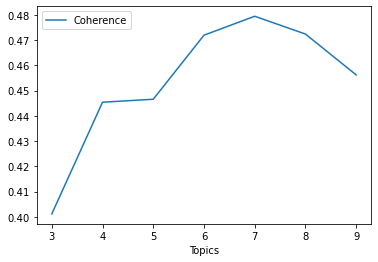

In [13]:
plot_data.plot.line(x='Topics', y='Coherence')


We can see that the coherence increases with number of topics until we reach 7, where the coherence begins to fall again, so 7 would be the best choice for the number of topics with these alpha and beta.

Now let's see which combination of factors increases the coherence the most.

In [14]:
max(optim_data.Coherence)

0.499681194035391

In [15]:
print(list(np.where(optim_data["Coherence"] == 0.499681194035391)))
print(list(np.where(optim_data["Coherence"] > 0.495)))

[array([407], dtype=int64)]
[array([149, 327, 407, 409], dtype=int64)]


In [16]:
optim_data[407:408]

,Validation_Set,Topics,Alpha,Beta,Coherence
407,100% Corpus,9,0.9099999999999999,0.61,0.499681


The highest coherence comes from the above parameters, but we have three other combinations which are very close.

In [17]:
optim_data[149:150]

,Validation_Set,Topics,Alpha,Beta,Coherence
149,75% Corpus,7,asymmetric,symmetric,0.497265


In [18]:
optim_data[327:328]

,Validation_Set,Topics,Alpha,Beta,Coherence
327,100% Corpus,6,asymmetric,0.61,0.498664


In [41]:
optim_data[409:410]

,Validation_Set,Topics,Alpha,Beta,Coherence
409,100% Corpus,9,0.9099999999999999,symmetric,0.495618


Optimising the hyperparamets has yielded an approximate 40% increase on the baseline coherence score, and we will now train the final model based on these hyperparameters.

In [ ]:
lda_model_optim = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=9, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.9099999999999999,
                                           eta=0.61)

Next, lets's print the top ten words and visualise the new topics.

In [ ]:
pprint(lda_model_optim.print_topics())

In [ ]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_optim, corpus, dictionary)
vis

These topics look quite different from the previous model, and we can see that we don't have quite as much overlap. Further, the topics 'make sense' intuitively, as for example we can see that we have one topic clearly linked to family, with words like 'father', 'son' and 'daugther', and another linked to crime, with words like 'murder', 'agent' and 'police'.

### Outputting the results of LDA 

We now need to output the results of the LDA model as a vector for each plot summary to input into the boosted prediction model.

The below code grabs the distribution of the 9 topics for every plot summary, and we then check that the code has produced the correct number of vectors.
We use minimum_probability=0.0 in line 3 to ensure that we’ll capture the instances where a plot is represented as 0% in some topics, and the representation for each plot will add up to 100%.

In [ ]:
train_vecs = []
for i in range(len(plots)):
    top_topics = (
        lda_model_optim.get_document_topics(corpus[i],
                                      minimum_probability=0.0)
    )
    topic_vec = [top_topics[i][1] for i in range(9)]
    train_vecs.append(topic_vec)

train_vecs[:5]

In [ ]:
len(train_vecs)

I now convert this to a pandas dataframe and export.

In [ ]:
output_df = pd.DataFrame(train_vecs, columns = ['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9'])
output_df[:5]

In [ ]:
output_df.to_csv('./Data/LDA_topics.csv')

### Synonym extension

Here we briefly look at how using the synonym data impacts coherence.

In [28]:
synonym_stringed_data = pd.read_csv('../Data/synonym_stringed_plots.csv')

#convert to list of lists
s_plots=[]
for i in range(0,len(synonym_stringed_data)):
    data=np.array(synonym_stringed_data.iloc[i])
    text=data[1]
    text=text.replace(',','')
    text=text.replace('[','')
    text=text.replace(']','')
    text=text.replace("'",'')
    tokens=word_tokenize(text)
    s_plots.append(tokens)
    
s_plots[:5]

[['kaisa',
  'scot',
  'successful',
  'london',
  'lawyer',
  'snow',
  'night',
  'base',
  'aberdeen',
  'story',
  'begging',
  'flee',
  'collect',
  'alcoholic',
  'dad',
  'hasnt',
  'find',
  'impatient',
  'hold',
  'ruse',
  'mom',
  'break',
  'want',
  'daughter',
  'trip',
  'take',
  'complicate',
  'drunk',
  'live',
  'season',
  'ban',
  'airline',
  'get',
  'ferry',
  'car',
  'big',
  'care',
  'help',
  'along',
  'way',
  'fresh',
  'lorry',
  'driver',
  'make',
  'clive',
  'give',
  'end',
  'stability'],
 ['plague',
  'endless',
  'jenny',
  'suspect',
  'child',
  'responsible',
  'brutal',
  'murder',
  'mother'],
 ['novel',
  'young',
  'nicotine',
  'addict',
  'traveler',
  'make',
  'richard',
  'avid',
  'kill',
  'culture',
  'lover',
  'special',
  'love',
  'video',
  'vietnam',
  'war',
  'hotel',
  'bangkok',
  'map',
  'give',
  'strange',
  'whack',
  'place',
  'suicide',
  'lead',
  'legendary',
  'island',
  'paradise',
  'wayward',
  'someone

In [29]:
s_dictionary = gensim.corpora.Dictionary(s_plots)

count = 0
for k,v  in s_dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break
        
s_dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
# gets rid of too common or uncommon words

#corpus
s_corpus = [s_dictionary.doc2bow(text) for text in s_plots ]  

s_lda_model = gensim.models.LdaMulticore(corpus=s_corpus,
                                           id2word=s_dictionary,
                                           num_topics=9, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.9099999999999999,
                                           eta=0.61)

s_coherence_model_lda = CoherenceModel(model=s_lda_model, texts=s_plots, dictionary=s_dictionary, coherence='c_v')
s_coherence_lda = s_coherence_model_lda.get_coherence()
print('Coherence Score: ', s_coherence_lda)

0 aberdeen
1 airline
2 alcoholic
3 along
4 ban
5 base
6 begging
7 big
8 break
9 car
10 care
Coherence Score:  0.4844295644034309


Here we didn't optimise the parameters for the specific synonym model and the coherence is similar to (although slightly less than) the previous model. We can visualise the topics to see if they are different.

In [31]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(s_lda_model, s_corpus, s_dictionary)
vis

C:\Users\user\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.117123  0.048317       1        1  13.494928
8      0.129416  0.076727       2        1  12.733374
3      0.012445  0.146357       3        1  11.061393
1      0.009402 -0.130933       4        1  10.803304
4      0.123576 -0.093243       5        1  10.753682
7     -0.115232 -0.113775       6        1  10.555535
6      0.010639 -0.022200       7        1  10.483398
5     -0.119515 -0.054495       8        1  10.122016
2     -0.167853  0.143245       9        1   9.992371, topic_info=         Term         Freq        Total Category  logprob  loglift
30      story  1036.000000  1036.000000  Default  30.0000  30.0000
294      film   572.000000   572.000000  Default  29.0000  29.0000
96     friend   704.000000   704.000000  Default  28.0000  28.0000
66      young  1023.000000  1023.000000  Default  27.0000  27.0000
451    school   594.000000   594.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
66      young   128.008438  1023.200458   Topic9  -5.0181   0.2248
341  struggle   115.581544   651.713516   Topic9  -5.1202   0.5737
170    family   125.593973  1493.471782   Topic9  -5.0371  -0.1725
32       take   126.475627  3212.366083   Topic9  -5.0302  -0.9314
378      head   103.452745   596.691043   Topic9  -5.2311   0.5511

[546 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
997       1  0.006350  abandon
997       2  0.006350  abandon
997       3  0.006350  abandon
997       4  0.920814  abandon
997       5  0.006350  abandon
...     ...       ...      ...
66        5  0.011728    young
66        6  0.008796    young
66        7  0.016615    young
66        8  0.021501    young
66        9  0.125098    young

[3924 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 9, 4, 2, 5, 8, 7, 6, 3])

The topics look farily similar to the previous model, as we can still see topics clearly related to war, murder and family. However it will still be an interesting exercise to see whether the synonym topics affect the prediction of IMDb differently so I export the results below.

### Outputting synonym LDA vectors

In [33]:
s_train_vecs = []
for i in range(len(s_plots)):
    top_topics = (
        s_lda_model.get_document_topics(s_corpus[i],
                                      minimum_probability=0.0)
    )
    topic_vec = [top_topics[i][1] for i in range(9)]
    s_train_vecs.append(topic_vec)

s_train_vecs[:5]

[[0.28238714,
  0.08436398,
  0.05320083,
  0.03339375,
  0.16177876,
  0.025937112,
  0.19498678,
  0.05837599,
  0.10557565],
 [0.20488495,
  0.15520853,
  0.05494987,
  0.05589011,
  0.28738555,
  0.05470723,
  0.058418103,
  0.061351497,
  0.06720421],
 [0.05203748,
  0.20122987,
  0.14560553,
  0.07684785,
  0.15571873,
  0.17790501,
  0.03296228,
  0.056453772,
  0.101239435],
 [0.22237636,
  0.104968086,
  0.031250983,
  0.17137547,
  0.10750581,
  0.11159073,
  0.1843778,
  0.034981426,
  0.03157331],
 [0.0728026,
  0.05623479,
  0.042328168,
  0.044691514,
  0.055214,
  0.042991433,
  0.05007878,
  0.047540177,
  0.5881185]]

In [34]:
len(s_train_vecs)

6732

In [35]:
s_output_df = pd.DataFrame(s_train_vecs, columns = ['t1', 't2', 't3', 't4', 't5', 't6', 't7', 't8', 't9'])
s_output_df[:5]

,t1,t2,t3,t4,t5,t6,t7,t8,t9
0,0.282387,0.084364,0.053201,0.033394,0.161779,0.025937,0.194987,0.058376,0.105576
1,0.204885,0.155209,0.054950,0.055890,0.287386,0.054707,0.058418,0.061351,0.067204
2,0.052037,0.201230,0.145606,0.076848,0.155719,0.177905,0.032962,0.056454,0.101239
3,0.222376,0.104968,0.031251,0.171375,0.107506,0.111591,0.184378,0.034981,0.031573
4,0.072803,0.056235,0.042328,0.044692,0.055214,0.042991,0.050079,0.047540,0.588118


In [36]:
s_output_df.to_csv('LDA_topics_synonym.csv')

### References 

1. https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0 
2. https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28
3. https://medium.com/analytics-vidhya/topic-modeling-using-gensim-lda-in-python-48eaa2344920